In [1]:
from __future__ import print_function
path = '../dataset/facebook/'
filenames = ['0', '107', '348', '414', '686', '698', '1684', '1912', '3437', '3980']

In [2]:
nodes = 4039
feature_total_number = 1283
feature_matrix = [[0 for i in range(feature_total_number)] for j in range(nodes)]

In [3]:
for filename in filenames:
    features = []
    file_featnames = open(path + filename + '.featnames', 'r')
    for i, line in enumerate(file_featnames):
        line_split = line.split(';')
        feature_number = line_split[-1].split(' ')
        features.append(int(feature_number[-1]))
    file_featnames.close()
    
    file_feat = open(path + filename + '.feat', 'r')
    for line in file_feat:
        line_split = line.split(' ')
        node_number = int(line_split[0])
        for i, x in enumerate(line_split[1:]):
            if x == '1':
                feature_matrix[node_number][features[i]] = 1
    file_feat.close()
    
    file_egofeat = open(path + filename + '.egofeat', 'r')
    for line in file_egofeat:
        line_split = line.split(' ')
        for i, x in enumerate(line_split):
            if x == '1':
                feature_matrix[int(filename)][features[i]] = 1

In [4]:
output_file = open('../dataset/features.txt', 'w')
for i in feature_matrix:
    for j in i:
        print(j,file=output_file,end = ' ')
    print(file=output_file)

In [5]:
import numpy as np

def normalize_vector(x):
    minx = min(x)
    maxx = max(x)
    x = (x - minx) / ((maxx - minx) * 1.0)
    return x

In [6]:
from igraph import *
import pandas as pd

def intersect(x, y):
    return list(set(x) & set(y))

def get_graph():
    graph = Graph.Read_Ncol("../dataset/facebook_combined.txt", directed = False)
    dataset = pd.read_csv("../dataset/features.txt", header = None, sep = ' ')
    num_features = dataset.shape[1]
    v = graph.vcount()
    e = graph.ecount()
        
    features = []
    
    for i in range(0, v - 1):
        features_i = []
        for j in range(0, num_features):
            if dataset[j][i] == 1:
                features_i.append(j)
        features.append(features_i)
    
    ends_graph = graph.get_edgelist()
    
    # Edge weight are number of common features between the nodes
    for i in range(0, graph.ecount()):
        graph.es[i]['weight'] = len(intersect(features[graph.es[i].source - 1], features[graph.es[i].target - 1]))

    return graph

In [7]:
graph = get_graph()

In [8]:
import math

def make_ego_graphs(graph):
    ego_graph = []
    for vertex in graph.vs():
        g = Graph()
        vertices = [vertex.index]
        edges = []
        weights = []
        for edge in graph.es():
            if edge.source == vertex.index or edge.target == vertex.index:
                edges.append((edge.source, edge.target))
                weights.append(edge['weight'])
                if edge.source == vertex.index:
                    vertices.append(edge.target)
                else:
                    vertices.append(edge.source)
        g.add_vertices(len(vertices))
        for edge in edges:
            g.add_edge(vertices.index(edge[0]), vertices.index(edge[1]))
        g.es['weight'] = weights
        ego_graph.append(g)
    return ego_graph

In [9]:
ego_graphs = make_ego_graphs(graph)

In [10]:
def ego_vsize(ego_graphs):
    ego_vertexsize = []
    for ego_graph in ego_graphs:
        ego_vertexsize.append(ego_graph.vcount())
    return ego_vertexsize

def ego_esize(ego_graphs):
    ego_edgesize = []
    for ego_graph in ego_graphs:
        ego_edgesize.append(ego_graph.ecount())
    return ego_edgesize

def ego_weights(ego_graphs):
    ego_weights = []
    for ego_graph in ego_graphs:
        ego_weight = 1
        for edge in ego_graph.es():
            ego_weight += edge['weight']
        ego_weights.append(ego_weight)
    return ego_weights

def ego_eigen_values(ego_graphs):
    ego_eigen_values = []
    for ego_graph in ego_graphs:
        A = ego_graph.get_adjacency(attribute = 'weight')
        adj = []
        for row in A:
            adj.append(row)
        evals, evecs = np.linalg.eig(np.array(adj))
        idx = evals.argsort()[::-1]   
        evals = evals[idx]
        ego_eigen_values.append(evals[0])
    return ego_eigen_values

In [11]:
def get_outlierness_EDPL():
    v = graph.vcount()
    e = graph.ecount()
    
    ego_vertexsize = ego_vsize(ego_graphs)

    ego_edgesize = ego_esize(ego_graphs)
    
    c = 1
    alpha = 0.5
    
    outlierness = []
    for i in range(0, v):
        outlierness.append((max(ego_edgesize[i], c * (ego_vertexsize[i] ** alpha)) / min(ego_edgesize[i], c * (ego_vertexsize[i] ** alpha))) * (math.log(abs(ego_edgesize[i] - c * (ego_vertexsize[i] ** alpha)) + 1)))
    
    outlierness = normalize_vector(np.asarray(outlierness))
    return outlierness

In [12]:
def get_outlierness_EWPL():
    v = graph.vcount()
    e = graph.ecount()

    ego_edgesize = ego_esize(ego_graphs)

    ego_weight = ego_weights(ego_graphs)

    c = 1
    beta = 1.15
        
    outlierness = []
    
    for i in range(0, v):
        outlierness.append((max(ego_weight[i], c * (ego_edgesize[i] ** beta)) / min(ego_weight[i], c * (ego_edgesize[i] ** beta))) * (math.log(abs(ego_weight[i] - c * (ego_edgesize[i] ** beta)) + 1)))
    
    outlierness = normalize_vector(np.asarray(outlierness))
    return outlierness

In [13]:
def get_outlierness_ELWPL():
    v = graph.vcount()
    e = graph.ecount()

    ego_eigen_value = ego_eigen_values(ego_graphs)

    ego_weight = ego_weights(ego_graphs)

    c = 1
    gamma = 0.75
    
    outlierness = []
    
    for i in range(0, v):
        div_val = min(ego_eigen_value[i], c * (ego_weight[i] ** gamma))
        if div_val <= 0:
            div_val = 0.01
        outlierness.append((max(ego_eigen_value[i], c * (ego_weight[i] ** gamma)) / div_val) * (math.log(abs(ego_eigen_value[i] - c * (ego_weight[i] ** gamma)) + 1)))
    
    outlierness = normalize_vector(np.asarray(outlierness))
    return outlierness

In [14]:
o1 = get_outlierness_EDPL()
o2 = get_outlierness_EWPL()
o3 = get_outlierness_ELWPL()

outlierness = (o1 + o2 + o3) / 3

print(outlierness)

[0.22875658 0.02784904 0.01874947 ... 0.00093628 0.00394915 0.01560109]


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

def plotOutlierness(outlierness, title):
    plt.plot(outlierness)
    plt.scatter(range(0, graph.vcount()), outlierness, color = 'orange')
    plt.xlabel('Vertices')
    plt.ylabel('Total Outlierness Score')
    plt.title(title)
    plt.show()

In [16]:
def plotOutliers(outlierness, threshold, title):
    count = 0
    vertices = []
    outliers = []

    print('Outliers:\n')

    for i in range(0, graph.vcount()): 
        if outlierness[i] >= threshold:
            print('Vertex', graph.vs[i].index, ':', outlierness[i])
            outliers.append(outlierness[i])
            vertices.append(graph.vs[i].index)
            count = count + 1

    print('\nTotal number of Outliers: ', count)
    
    plt.plot(outlierness)
    plt.scatter(range(0, graph.vcount()), outlierness, color = 'orange')
    plt.scatter(vertices, outliers, color = 'red')
    plt.axhline(y = threshold, linestyle = 'dashed', color = 'red')
    plt.xlabel('Vertices')
    plt.ylabel('Total Outlierness Score')
    plt.title(title)
    plt.show()

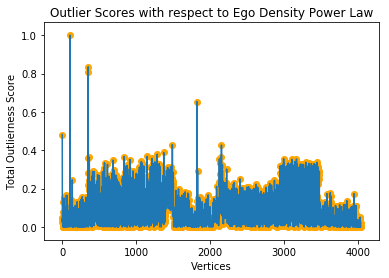

Outliers:

Vertex 107 : 1.0
Vertex 351 : 0.8348146928585662
Vertex 352 : 0.8090435417834726
Vertex 1821 : 0.6539309752809096

Total number of Outliers:  4


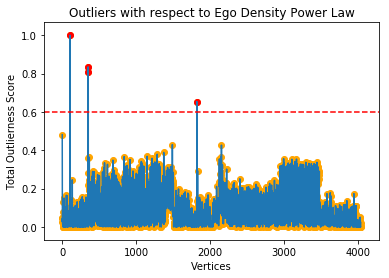

In [17]:
plotOutlierness(o1, 'Outlier Scores with respect to Ego Density Power Law')
plotOutliers(o1, 0.6, 'Outliers with respect to Ego Density Power Law')

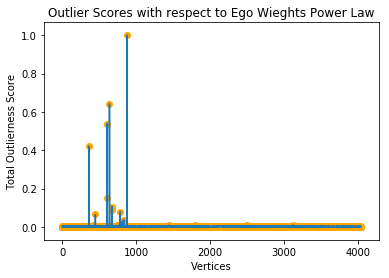

Outliers:

Vertex 359 : 0.42208573250276993
Vertex 603 : 0.5386665367854847
Vertex 639 : 0.6428492919570402
Vertex 876 : 1.0

Total number of Outliers:  4


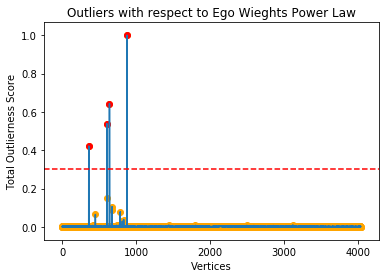

In [18]:
plotOutlierness(o2, 'Outlier Scores with respect to Ego Wieghts Power Law')
plotOutliers(o2, 0.3, 'Outliers with respect to Ego Wieghts Power Law')

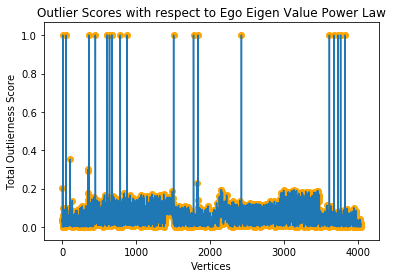

Outliers:

Vertex 12 : 1.0
Vertex 52 : 1.0
Vertex 359 : 1.0
Vertex 448 : 1.0
Vertex 603 : 1.0
Vertex 608 : 1.0
Vertex 639 : 1.0
Vertex 669 : 1.0
Vertex 675 : 1.0
Vertex 785 : 1.0
Vertex 876 : 1.0
Vertex 1507 : 1.0
Vertex 1776 : 1.0
Vertex 1837 : 1.0
Vertex 2424 : 1.0
Vertex 3614 : 1.0
Vertex 3676 : 1.0
Vertex 3730 : 1.0
Vertex 3766 : 1.0
Vertex 3825 : 1.0

Total number of Outliers:  20


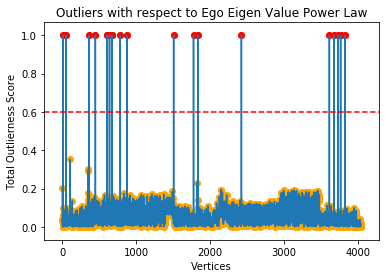

In [19]:
plotOutlierness(o3, 'Outlier Scores with respect to Ego Eigen Value Power Law')
plotOutliers(o3, 0.6, 'Outliers with respect to Ego Eigen Value Power Law')

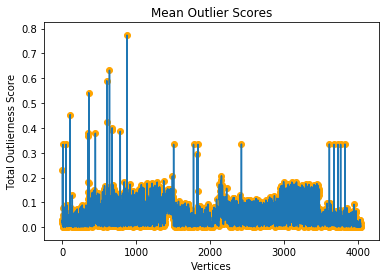

Outliers:

Vertex 359 : 0.541578539718867
Vertex 603 : 0.5899274784286878
Vertex 639 : 0.6322944013781863
Vertex 876 : 0.7736506794991137

Total number of Outliers:  4


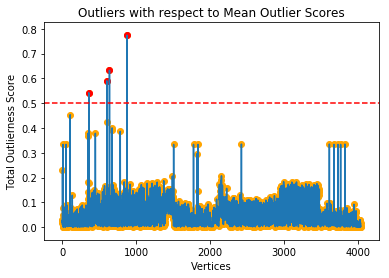

In [20]:
plotOutlierness(outlierness, 'Mean Outlier Scores')
plotOutliers(outlierness, 0.5, 'Outliers with respect to Mean Outlier Scores')

In [21]:
from __future__ import division

def getIteratedNodeRank(outlierness):
    adj = np.asmatrix(graph.get_adjacency(attribute = 'weight').data, dtype = np.float)
    rowsums = np.array(adj.sum(axis = 1))[:, 0]

    for i, val in enumerate(rowsums):
        if val == 0:
            rowsums[i] = 1

    n = adj.shape[0]

    for i in range(0, n):
        adj[i] /= rowsums[i]

    adj = np.transpose(adj)

    U = []
    for i in range(0, n):
        U.append([1.0/n for i in range(0, n)])
    beta = 0.85

    U = np.asmatrix(U)

    A = beta * adj + (1 - beta) * U

    P = []

    for i, val in enumerate(outlierness):
        P.append([val])

    for i in range(0, 100):
        P = np.matmul(A, P)
        
    return np.squeeze(np.asarray(P))

In [22]:
o4 = getIteratedNodeRank(o1)
o5 = getIteratedNodeRank(o2)
o6 = getIteratedNodeRank(o3)

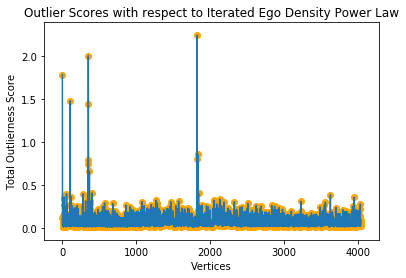

Outliers:

Vertex 0 : 1.788233008375647
Vertex 107 : 1.4830604207368219
Vertex 351 : 2.0087311341847607
Vertex 352 : 1.4511114846468227
Vertex 1821 : 2.2485844684769702

Total number of Outliers:  5


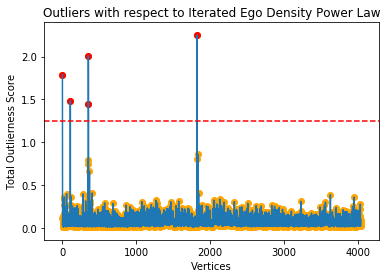

In [23]:
plotOutlierness(o4, 'Outlier Scores with respect to Iterated Ego Density Power Law')
plotOutliers(o4, 1.25, 'Outliers with respect to Iterated Ego Density Power Law')

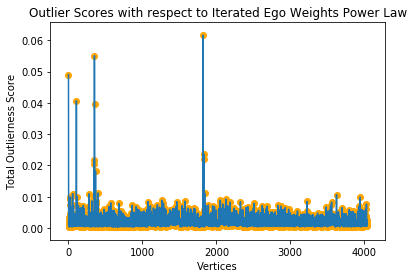

Outliers:

Vertex 0 : 0.04899328847241856
Vertex 107 : 0.04063229169013937
Vertex 351 : 0.05503440646619437
Vertex 352 : 0.039756966546132505
Vertex 1821 : 0.06160581217397964

Total number of Outliers:  5


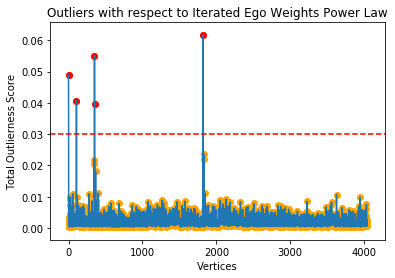

In [24]:
plotOutlierness(o5, 'Outlier Scores with respect to Iterated Ego Weights Power Law')
plotOutliers(o5, 0.03, 'Outliers with respect to Iterated Ego Weights Power Law')

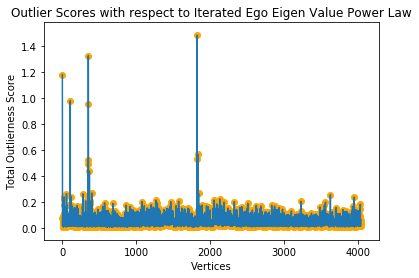

Outliers:

Vertex 0 : 1.181678801711665
Vertex 107 : 0.9800182876685746
Vertex 351 : 1.3273857412895764
Vertex 352 : 0.9589061663096442
Vertex 1821 : 1.4858827672892931

Total number of Outliers:  5


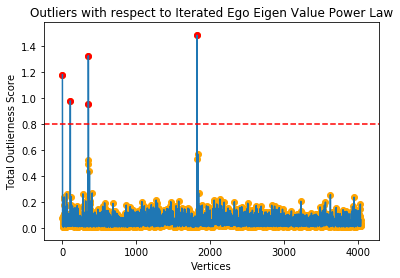

In [25]:
plotOutlierness(o6, 'Outlier Scores with respect to Iterated Ego Eigen Value Power Law')
plotOutliers(o6, 0.8, 'Outliers with respect to Iterated Ego Eigen Value Power Law')

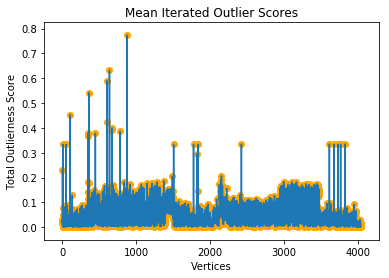

Outliers:

Vertex 359 : 0.541578539718867
Vertex 603 : 0.5899274784286878
Vertex 639 : 0.6322944013781863
Vertex 876 : 0.7736506794991137

Total number of Outliers:  4


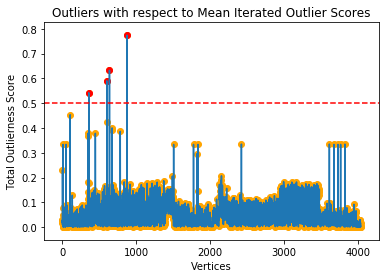

In [26]:
plotOutlierness(outlierness, 'Mean Iterated Outlier Scores')
plotOutliers(outlierness, 0.5, 'Outliers with respect to Mean Iterated Outlier Scores')

In [27]:
def getThresholdedOutlierness(outlierness, t1, t2):
    t_outlierness = []
    
    for i, val in enumerate(outlierness):
        if val < t1:
            t_outlierness.append(0)
        elif val < t2:
            t_outlierness.append(1)
        else:
            t_outlierness.append(2)
    
    return t_outlierness

In [28]:
thresholds = [[0.3, 0.6], [0.05, 0.3], [0.15, 0.6], [0.3, 1.25], [0.008, 0.03], [0.2, 0.8]]
outliernesses = [o1, o2, o3, o4, o5, o6]
t_outliernesses = []

for i, outlierness in enumerate(outliernesses):
    t_outliernesses.append(getThresholdedOutlierness(outlierness, thresholds[i][0], thresholds[i][1]))
    
print(t_outliernesses)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
t_o1, t_o2, t_o3, t_o4, t_o5, t_o6 = t_outliernesses

In [30]:
def get_true_ego_vertices(graph):
    ego_vertices = []
    for vertex in graph.vs():
        vertices = [vertex.index]
        for edge in graph.es():
            if edge.source == vertex.index or edge.target == vertex.index:
                if edge.source == vertex.index:
                    vertices.append(edge.target)
                else:
                    vertices.append(edge.source)
        ego_vertices.append(vertices)
    return ego_vertices

In [31]:
ego_vertices = get_true_ego_vertices(graph)

In [32]:
def get_neighbor_outlierness_metrics(outlierness):
    n_o = []
    
    for i, ego_graph in enumerate(ego_graphs):
        o = 0
        for edge in ego_graph.es():
            vertex = edge.target
            if edge.target == 0:
                vertex = edge.source
            
            o += pow(edge['weight'], outlierness[ego_vertices[i][vertex]])
            
        n_o.append(o)
        
    return n_o

In [33]:
n_o1 = get_neighbor_outlierness_metrics(t_o1)
n_o2 = get_neighbor_outlierness_metrics(t_o2)
n_o3 = get_neighbor_outlierness_metrics(t_o3)

In [34]:
features = [o1, o2, o3, o4, o5, o6, t_o1, t_o2, t_o3, t_o4, t_o5, t_o6, n_o1, n_o2, n_o3]

features = np.transpose(features)

In [35]:
import csv

dataset = open('anomaly_features.csv', 'w')

print('Writing to csv file...')

with dataset:
    writer = csv.writer(dataset)
    writer.writerows(features)
    
print('Write complete.')

Writing to csv file...
Write complete.
